# 0) Imports

In [625]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [626]:
# %matplotlib inline

In [627]:
import os
import numpy as np
import pandas as pd
from time import time

import matplotlib.pyplot as plt
import plotly.graph_objects as go

# 1) Personal tools and solvers

In [628]:
from utils import is_symmetric, is_pos_def, is_commutative, res_norm_pr, rel_err_pr
from plots import plot_conv, plot_eigenvals, plot_conv_plotly
from results import ResultPR

from gen_data import gen_artifical_pr
from adi_peaceman_rachford import adi_pr, sap_adi_pr
from shift_parameters import shifts_pr, shifts_w

from save_load import save, save_artificial_pr, load_artificial_pr

### Parameters to select

In [642]:
N = 8000  # dimension
spectra = "negative"


overwrite = True  # overwrite matrices
n_iter_moving_shifts = 20  # number iterations PR and W shifts
n_iter_cst_shifts = 500  # number iterations cst shifts
n_iter = 500  # number iterations SPR

is_plot_spectrum = False  # plot spectrum of matrices A and B


# Plots title
title = f"Peaceman-Rachford problem N={N}"

# 2) Generate input matrices and vector

## Load or generate data

In [630]:
filename = f"artificial_pr_{N}_{spectra}.npz"
folder = os.path.join(os.getcwd(), "datasets/pr/")
path = os.path.join(folder, filename)

if os.path.exists(path) and not overwrite:
    H, V, b, u_true = load_artificial_pr(N, spectra)
    print("Matrices loaded from\n", path)
else:
    np.random.seed(0)
    H, V, b, u_true = gen_artifical_pr(N, spectra)
    save_artificial_pr(H, V, b, u_true, spectra)
    print("Matrices saved in\n", path)
    
m = H.shape[0]
print("Shape of H :", m)

Matrices saved in
 /home/claire/nidham/thomas_jefferson_fund/sketch_proj_ADI/code/sketched_adi/datasets/pr/artificial_pr_8000_negative.npz
Shape of H : 8000


In [631]:
# Check that u_true is a solution
if u_true.size == 0:
    print("Solution not provided")
else:
    if res_norm_pr(u_true, H, V, b) < 1e-3:
        print("The problem is well posed")
#         u_direct = np.linalg.solve(H + V, b) # computed solution
#         print(res_norm_pr(u_direct, H, V, b))
#         print(np.linalg.norm(u_direct - u_true)) # u_true: ground truth solution
    else:
        print("The problem does not have a solution")
        u_true = np.array([])

The problem is well posed


In [632]:
# Estimate eigenvalue interval
t0 = time()
eig_val_H = np.linalg.eigvals(H)
eig_val_V = np.linalg.eigvals(V)

all_eig_val = np.concatenate((eig_val_H, eig_val_V))
alpha = np.min(all_eig_val)
beta = np.max(all_eig_val)
t_eigvalsh = time() - t0

print(
    f"Spectrum of H: [{np.min(eig_val_H):.5f}, {np.max(eig_val_H):.5f}]"
    f" => condition number (H) = {np.linalg.cond(H):.0f}"
)
print(
    f"Spectrum of V: [{np.min(eig_val_V):.5f}, {np.max(eig_val_V):.5f}]"
    f" => condition number (V) = {np.linalg.cond(V):.0f}"
)

print(f"Eigenvalue interval [alpha, beta] = [{alpha}, {beta}]\n")
print(f"Time numpy eigvalsh: {t_eigvalsh:.2} s\n")

print(f"Condition number (H + V) = {np.linalg.cond(H + V):.0f}")

Spectrum of H: [8.00000+0.00000j, 1008.00000+0.00000j] => condition number (H) = 126
Spectrum of V: [-100.00500+0.00000j, -0.00500+0.00000j] => condition number (V) = 20001
Eigenvalue interval [alpha, beta] = [(-100.00500000000028+0j), (1008.0000000000051+0j)]

Time numpy eigvalsh: 3.7e+02 s

Condition number (H + V) = 114


In [633]:
# negative
init = 1e-3
mu = .1
power = 2e-3
print(init + np.exp(-mu*100) / power, init + np.exp(-mu*0) / power)
print(init + np.exp(-mu*1000) / power, init + np.exp(-mu*0) / power)
print(init + np.exp(-mu*2500) / power, init + np.exp(-mu*0) / power)
print(init + np.exp(-mu*5000) / power, init + np.exp(-mu*0) / power, "\n")

init = -5.
mu = .087
power = 1e-2
print(init + np.exp(-mu*100) / power, init + np.exp(-mu*0) / power)
print(init + np.exp(-mu*1000) / power, init + np.exp(-mu*0) / power)
print(init + np.exp(-mu*2500) / power, init + np.exp(-mu*0) / power)
print(init + np.exp(-mu*5000) / power, init + np.exp(-mu*0) / power)

0.023699964881242427 500.001
0.001 500.001
0.001 500.001
0.001 500.001 

-4.983341418901237 95.0
-5.0 95.0
-5.0 95.0
-5.0 95.0


## Remark
H + V = H - (- V), sp(H) and sp(-V) must be separated enough
a = min eig (H), b = max eig (H)
c = min eig (-V), d = max eig (-V)

gam = (c - a )*( d - b )/( c - b )/( d - a ); % Cross - ratio of a ,b ,c , d
=> Measures the "difficulty" of the problem 

AX - XB = F when the eigenvalues of A ( B ) are in [a , b ] and
% the eigenvalues of B ( A ) are in [c , d ]

In [634]:
if is_plot_spectrum:
    # Plot eigenvalues decrease
    plot_eigenvals(eig_val_H, eig_val_V, "pr")

Condition number (H + V) = 114
False


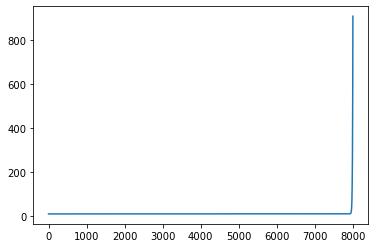

In [635]:
plt.plot(np.linalg.eigvalsh(H+V))
print(f"Condition number (H + V) = {np.linalg.cond(H + V):.0f}")
print(any(np.linalg.eigvalsh(H+V)<0))
# print(np.linalg.eigvalsh(H+V))

# 3) ADI to solve Peaceman-Rachford problem

## Solvers parameters

In [643]:
results = []

# a) Test ADI with Peaceman-Rachford shifts

# b) Test ADI with Wachspress shifts

# c) Test ADI with constant shifts p = q = beta (upper bound of eigenvalues)

In [644]:
def normalize(x):
    fac = abs(x).max()
    x_n = x / x.max()
    return fac, x_n

In [645]:
t0 = time()
x = np.ones(m)
for i in range(10):
    x = np.dot(H, x)
    lambda_max_H, x = normalize(x)

x = np.ones(m)
for i in range(10):
    x = np.dot(V, x)
    lambda_max_V, x = normalize(x)

t_power_method = time() - t0


beta_estimate = max(lambda_max_H, lambda_max_V)
print(f"Beta estimate: {beta_estimate}")
print(f"Beta: {beta}")

print(f"Time power method: {t_power_method:.2} s")

Beta estimate: 1058.913450030197
Beta: (1008.0000000000051+0j)
Time power method: 0.37 s


In [646]:
# With constant shifts
u_adi_cst, t_adi_cst, iter_adi_cst, epoch_adi_cst = adi_pr(
    H, V, b, 
    n_iter=n_iter_cst_shifts, 
#     p=beta, q=beta,
    p=beta_estimate, q=beta_estimate,
    store_every=int(n_iter_cst_shifts/10),
    verbose=True
)

# Taking initialization into account
# t_power_method : time to compute spectrum upper bounds
t_adi_cst += t_power_method

result_adi_cst = ResultPR(
    "PR-cst", 
    u_adi_cst, t_adi_cst, iter_adi_cst, epoch_adi_cst,
    u_true,
)
result_adi_cst.compute_errors(H, V, b)

results.append(result_adi_cst)

print(f"\nRelative residual of last iterate: {result_adi_cst.rel_res[-1]:.2e}")
if not result_adi_cst.rel_err.size == 0:
    print(f"Relative error of last iterate: {result_adi_cst.rel_err[-1]:.2e}")

--------------------------------------------
  Iteration   |    Epoch     |   Time (s)   
--------------------------------------------
      50      |      50      |   8.86e+02   
     100      |     100      |   1.78e+03   
     150      |     150      |   2.68e+03   
     200      |     200      |   3.57e+03   
     250      |     250      |   4.45e+03   
     300      |     300      |   5.35e+03   
     350      |     350      |   6.24e+03   
     400      |     400      |   7.13e+03   
     450      |     450      |   8.04e+03   
     500      |     500      |   8.92e+03   

Relative residual of last iterate: 1.77e-04
Relative error of last iterate: 5.23e-04


# d) Sketch and Project ADI with shift parameters

In [647]:
fracs = [.1, .25]
for size_frac in fracs:
    sketch_size = int(size_frac*N) # run same number of epochs
#     if size_frac == .1:
#         n_iter_sto = int(2*n_iter/size_frac)
#     else:
    n_iter_sto = int(n_iter/size_frac)
    print(f"Problem of size: {N} | sketch dimension: {sketch_size} ({int(100*size_frac)}% of rows)")
    print(f"Number of iterations: {n_iter_sto}")

    beta_array = beta*np.ones(n_iter_sto)
    np.random.seed(0)
    u_sketch, t_sketch, iter_sketch, epoch_sketch = sap_adi_pr(
        H, V, b, 
        n_iter=n_iter_sto, 
        p=beta_array, q=beta_array,
        sketch_size=sketch_size, 
        store_every=int(n_iter_sto/10),
        verbose=True,
    )
    
    # Taking initialization into account
    # t_power_method : time to compute spectrum upper bounds
    t_sketch += t_power_method

    result_sketched_adi_cst_shifts = ResultPR(
        "BSPR-cst-" + str(size_frac), 
        u_sketch, t_sketch, iter_sketch, epoch_sketch,
        u_true
    )
    result_sketched_adi_cst_shifts.compute_errors(H, V, b)

    results.append(result_sketched_adi_cst_shifts)

    print(f"\nRelative residual of last iterate: {result_sketched_adi_cst_shifts.rel_res[-1]:.2e}")
    if not result_sketched_adi_cst_shifts.rel_err.size == 0:
        print(f"Relative error of last iterate: {result_sketched_adi_cst_shifts.rel_err[-1]:.2e}")
    print("\n")

Problem of size: 8000 | sketch dimension: 800 (10% of rows)
Number of iterations: 5000
--------------------------------------------
  Iteration   |    Epoch     |   Time (s)   
--------------------------------------------
     500      |     50.0     |   1.47e+03   
     1000     |    100.0     |   2.97e+03   
     1500     |    150.0     |   4.45e+03   
     2000     |    200.0     |   5.93e+03   
     2500     |    250.0     |   7.42e+03   
     3000     |    300.0     |   8.93e+03   
     3500     |    350.0     |   1.04e+04   
     4000     |    400.0     |   1.19e+04   
     4500     |    450.0     |   1.34e+04   
     5000     |    500.0     |   1.48e+04   

Relative residual of last iterate: 1.29e-04
Relative error of last iterate: 3.82e-04


Problem of size: 8000 | sketch dimension: 2000 (25% of rows)
Number of iterations: 2000
--------------------------------------------
  Iteration   |    Epoch     |   Time (s)   
--------------------------------------------
     200      |  

# 4) Compare convergence plots: iterations and time

In [649]:
# plot_conv_plotly(results, title, prob="pr", x_axis="iter")
plot_conv_plotly(results, title, prob="pr", x_axis="epoch")
plot_conv_plotly(results, title, prob="pr", x_axis="time")

# 5) Save the results in csv and corresponding plots

In [651]:
# to run twice to avoid MathJax message on the plot
exp_name = f"artificial_N_{N}_spectra_{spectra}_a_tilde_{alpha:.2e}_b_tilde_{beta:.2e}"
# exp_name = f"artificial_N_{N}_spectra_{spectra}_a_tilde_{alpha:.2e}_b_tilde_{beta:.2e}_divergence_example"
save(results, title, "pr", exp_name)

Full path: /home/claire/nidham/thomas_jefferson_fund/sketch_proj_ADI/code/sketched_adi/outputs/pr/artificial_N_8000_spectra_negative_a_tilde_-1.00e+02+0.00e+00j_b_tilde_1.01e+03+0.00e+00j
Save results in csv
Save plots
